In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc_stats
import json
import random
import seaborn as sns

import spacy

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
rdm_th = 0
corr_th = 0.85

nlp_spanish = spacy.load("es_core_news_sm")

random.seed(rdm_th)

In [3]:
with open('../avoid_words.json', encoding='utf-8') as fh:
    avoid_words_list = json.load(fh)

tokenize_spanish = nltk.data.load('tokenizers/punkt/spanish.pickle')
spanish_stemmer = SpanishStemmer()
spanish_stopwords_th = stopwords.words('spanish')

In [4]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [5]:
path_to_conversations = "../Conversations/"

all_df_list = []
for conv in os.listdir(path_to_conversations):
    excel_name = [file for file in os.listdir(path_to_conversations + conv) if ".xlsx" in file][0]
    df_x = pd.read_excel(path_to_conversations + conv + "/" + excel_name)
    if df_x.shape[0] > 2:
        all_df_list.append(df_x)
            
print("Number of conversations:", len(all_df_list))

Number of conversations: 33


In [6]:
def clean_word(word):
    special_characters = ["?", "¿", "!", "¡", ".", ","]
    w_new = word.lower()
    for s_c in special_characters:
        w_new = w_new.replace(s_c, "")
        
    return w_new

def avoid_words_func(text):
    return " ".join([w for w in text.split() if clean_word(w) not in avoid_words_list])

def clean_text(text, subject_name, 
               tokenize_spanish=tokenize_spanish, 
               spanish_stopwords_th=spanish_stopwords_th, 
               spanish_stemmer=spanish_stemmer, 
               use_stemmer=True):
    
    text = text.lower()
    text = text.replace('?', "").replace('¿', "").replace('!', "").replace('¡', "")
    if subject_name:
        text = text.replace(subject_name, "")
    text = strip_accents(text)
    
    text_token_list = []
    if use_stemmer:
        for word in text.split():
            token_text = tokenize_spanish.tokenize(word)
            if len(token_text) > 0 and word not in spanish_stopwords_th:
                text_token_list.append(spanish_stemmer.stem(token_text[0]))
    else:
        text_token_list.append(text)
            
    text = " ".join(text_token_list)
    
    return text

In [7]:
save_res_list = []
for i_df_x, df_x in enumerate(all_df_list):
    
    subject_name = df_x["SubjectId"].iloc[0]
    
    # ###############
    # ### General ###
    # ###############
    num_conv = df_x.shape[0] // 2
    
    text = ". ".join(df_x["SpanishMessage"].values)
    whole_text = clean_text(text, subject_name)
    
    num_words = len(whole_text.split(" "))
    conv_time_s = df_x["UnixTimestampInit"].values[-1] - df_x["UnixTimestampEnd"].values[0]
    # freq_conv_s = np.mean(df_x["unixtimestamp"].values[1:] - df_x["unixtimestamp"].values[:-1])
    
    time_answer_list, time_bot_answer_list, time_pers_answer_list = [], [], []
    for i in range(df_x.shape[0]-1):
        if df_x["Source"].iloc[i] == "Person":
            delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
            time_bot_answer_list.append(delta_t)
        else:
            delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
            time_pers_answer_list.append(delta_t)

        delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
        time_answer_list.append(delta_t)
    
    # ###########
    # ### Bot ###
    # ###########
    df_bot = df_x[df_x["Source"] == "Bot"]
    
    text = ". ".join(df_bot["SpanishMessage"].values)
    bot_text = clean_text(text, subject_name)

    num_words_bot = len(bot_text.split(" "))
    
    # ##############
    # ### Person ###
    # ##############
    df_person = df_x[df_x["Source"] == "Person"]
    
    text = ". ".join(df_person["SpanishMessage"].values)
    person_text = clean_text(text, subject_name)
    
    num_words_person = len(person_text.split(" "))
    
    save_res_list.append({
        # General
        "SubjectId": df_x["SubjectId"].iloc[0],
        "FirstDate": df_x["UnixTimestampInit"].iloc[0],
        "LastDate": df_x["UnixTimestampEnd"].iloc[-1],
        "ConvTime_s": conv_time_s,
        # "FreqTime_s": freq_conv_s,
        "NumConv": num_conv,
        "NumSamples": df_x.shape[0],
        "AllText": avoid_words_func(whole_text),
        "AllNumUniqWords": len(set([w for w in whole_text.split() if w.isalpha()])),
        "AllOriginalText": avoid_words_func( ". ".join(df_x["SpanishMessage"].values) ),
        "AllNumWords": num_words,
        "AllTimeAns": np.mean(time_answer_list),
        # ### Bot ###
        "BotText": avoid_words_func(bot_text),
        "BotNumUniqWords": len(set([w for w in bot_text.split() if w.isalpha()])),
        "BotOriginalText": avoid_words_func( ". ".join(df_bot["SpanishMessage"].values) ),
        "BotNumWords": num_words_bot,
        "BotTimeAns": np.mean(time_bot_answer_list),
        # ### Person ###
        "PersonText": avoid_words_func(person_text),
        "PersonNumUniqWords": len(set([w for w in person_text.split() if w.isalpha()])),
        "PersonOriginalText": avoid_words_func( ". ".join(df_person["SpanishMessage"].values) ),
        "PersonNumWords": num_words_person,
        "PersonTimeAns": np.mean(time_pers_answer_list),
    })
    
df_save = pd.DataFrame(save_res_list)
df_save.head(5)

,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,AllNumUniqWords,AllOriginalText,AllNumWords,...,BotText,BotNumUniqWords,BotOriginalText,BotNumWords,BotTimeAns,PersonText,PersonNumUniqWords,PersonOriginalText,PersonNumWords,PersonTimeAns
0,Ana,1.658937e+09,1.658937e+09,196.524779,13,26,llamas. llamas. hol nombr hol nombr habl conti...,13,Como te llamas?. Como te llamas?. hola mi nomb...,53,...,llamas. hol nombr habl contigo. piens muerte. ...,13,Como te llamas?. hola mi nombre es estoy habla...,26,1.751842,llamas. hol nombr habl contigo. piens muerte. ...,13,Como te llamas?. hola mi nombre es estoy habla...,26,6.334660
1,jOSEID10,1.658677e+09,1.658677e+09,22.820666,3,6,llamas. llamas. bien tal cuentas. bien tal cue...,6,Como te llamas?. Como te llamas?. yo estoy muy...,17,...,llamas. bien tal cuentas. much graci llam guap,6,Como te llamas?. yo estoy muy bien y tú qué ta...,8,0.852903,llamas. bien tal cuentas. much graci llam guap,6,Como te llamas?. yo estoy muy bien y tú qué ta...,8,3.680018
2,Joseid10,1.658677e+09,1.658678e+09,117.104444,10,20,llamas. llamas. hol encant volv conocerte. hol...,19,Como te llamas?. Como te llamas?. hola yo lo e...,65,...,llamas. hol encant volv conocerte. plac mio en...,19,Como te llamas?. hola yo lo encantado de volve...,32,0.917468,llamas. hol encant volv conocerte. plac mio en...,19,Como te llamas?. hola yo lo encantado de volve...,32,4.134324
3,Joseid8,1.658673e+09,1.658673e+09,11.624342,5,11,llamas. llamas. llamas. llamas. llamas. llamas...,1,Como te llamas?. Como te llamas?. Como te llam...,11,...,llamas. llamas. llamas. llamas. llam,1,Como te llamas?. Como te llamas?. Como te llam...,5,0.370411,llamas. llamas. llamas. llamas. llamas. llam,1,Como te llamas?. Como te llamas?. Como te llam...,6,0.778020
4,Joseid8,1.658740e+09,1.658740e+09,89.409017,8,16,llamas. llamas. pues bien tal todo. pues bien ...,12,Como te llamas?. Como te llamas?. pues yo esto...,58,...,llamas. pues bien tal todo. pues bien cuentas....,12,Como te llamas?. pues yo estoy muy bien y tú q...,29,2.042253,llamas. pues bien tal todo. pues bien cuentas....,12,Como te llamas?. pues yo estoy muy bien y tú q...,29,2.770404


In [8]:
print("Shape", df_save.shape)
print("Columns", df_save.columns)

Shape (33, 21)
Columns Index(['SubjectId', 'FirstDate', 'LastDate', 'ConvTime_s', 'NumConv',
       'NumSamples', 'AllText', 'AllNumUniqWords', 'AllOriginalText',
       'AllNumWords', 'AllTimeAns', 'BotText', 'BotNumUniqWords',
       'BotOriginalText', 'BotNumWords', 'BotTimeAns', 'PersonText',
       'PersonNumUniqWords', 'PersonOriginalText', 'PersonNumWords',
       'PersonTimeAns'],
      dtype='object')


## EDA

In [9]:
aute.stat_print(df_save["ConvTime_s"]/60, "Conversation time (min)", 2)
aute.stat_print(df_save["NumSamples"], "Number Sentences ", 2)

Mean Conversation time (min) = 1.72 +/- 1.51 ; Median = 1.26 ; Min. =  0.18 ; Max. =  6.67
Mean Number Sentences  = 12.88 +/- 8.69 ; Median = 11.0 ; Min. =  4 ; Max. =  40


### Some plots

The following plots study the correlation of the number of words against the number of sentences and the time of the conversation. 

Correlation value 0.882450347793723
P-value ***
Coefficients: 
 [10.67849138] 
Intercept: 
 -11.641263034791926
R-square: 0.78


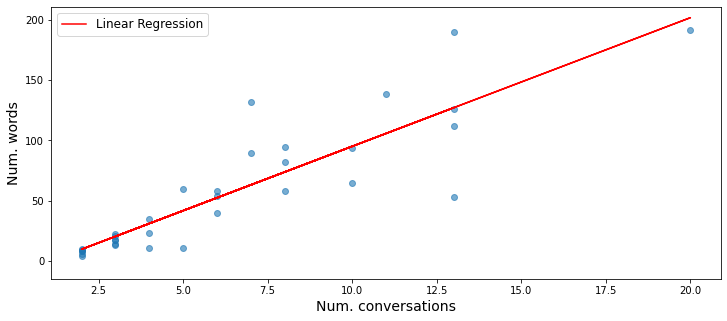

Correlation value 0.8281148545306424
P-value ***
Coefficients: 
 [0.48002914] 
Intercept: 
 7.10070523575407
R-square: 0.69


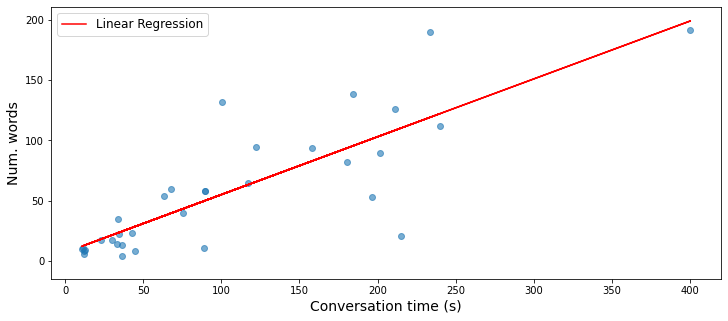

In [10]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="NumConv", x_name="Num. conversations", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="ConvTime_s", x_name="Conversation time (s)", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

Mean All number of words = 56.6364 +/- 52.531 ; Median = 40.0 ; Min. =  4 ; Max. =  192
Mean Person number of words = 28.2727 +/- 25.9758 ; Median = 20.0 ; Min. =  2 ; Max. =  96
Mean Bot number of words = 28.0303 +/- 26.8243 ; Median = 20.0 ; Min. =  2 ; Max. =  103
P-value 0.9708177172611033 string p value -


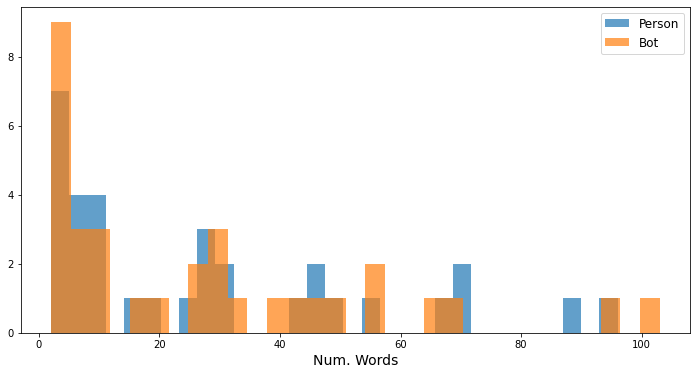

Mean Mean answer time (s) = 3.77 +/- 6.38 ; Median = 2.44 ; Min. =  0.31 ; Max. =  38.28
Mean Mean person answer time (s) = 7.52 +/- 16.09 ; Median = 4.57 ; Min. =  0.29 ; Max. =  95.54
Mean Mean bot answer time (s) = 1.08 +/- 1.16 ; Median = 0.71 ; Min. =  0.04 ; Max. =  4.52
P-value 0.027477206245967632 string p value *


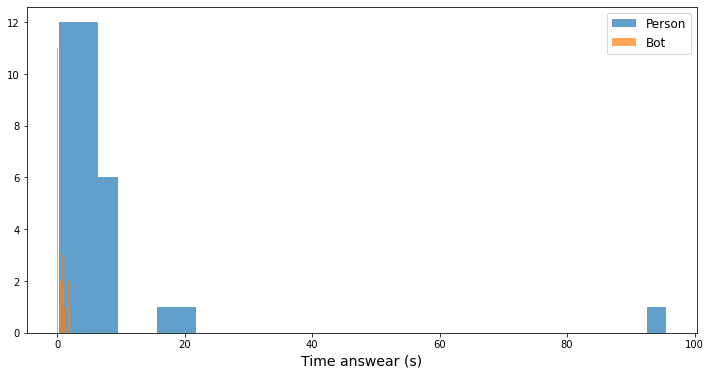

Mean All number of words = 17.2727 +/- 17.228 ; Median = 12.0 ; Min. =  1 ; Max. =  73
Mean Person unique words = 15.3636 +/- 13.2249 ; Median = 12.0 ; Min. =  1 ; Max. =  50
Mean Bot unique words = 14.7273 +/- 13.2968 ; Median = 12.0 ; Min. =  1 ; Max. =  50
P-value 0.8483875492892546 string p value -


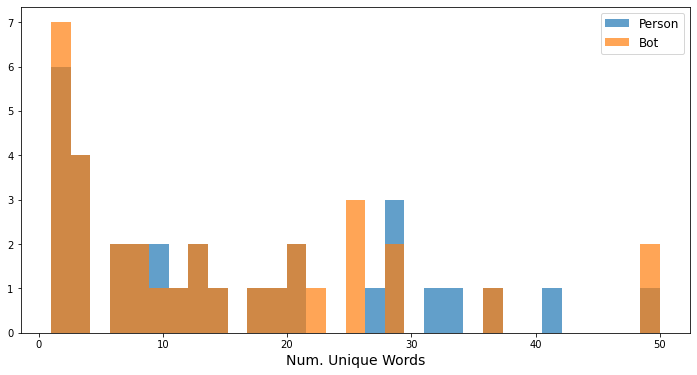

In [11]:
# #######################
# ### Number of words ###
# #######################

aute.stat_print(df_save["AllNumWords"].values, "All number of words")
aute.stat_print(df_save["PersonNumWords"].values, "Person number of words")
aute.stat_print(df_save["BotNumWords"].values, "Bot number of words")
_, p = sc_stats.f_oneway(df_save["PersonNumWords"].values, df_save["BotNumWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

# ###################
# ### Time answer ###
# ###################

aute.stat_print(df_save["AllTimeAns"].values, "Mean answer time (s)", 2)
aute.stat_print(df_save["PersonTimeAns"].values, "Mean person answer time (s)", 2)
aute.stat_print(df_save["BotTimeAns"].values, "Mean bot answer time (s)", 2)
_, p = sc_stats.f_oneway(df_save["PersonTimeAns"].values, df_save["BotTimeAns"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonTimeAns"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotTimeAns"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Time answear (s)", fontsize=14)
plt.legend(fontsize=12)

plt.show()

# ####################
# ### Unique words ###
# ####################

aute.stat_print(df_save["AllNumUniqWords"].values, "All number of words")
aute.stat_print(df_save["PersonNumUniqWords"].values, "Person unique words")
aute.stat_print(df_save["BotNumUniqWords"].values, "Bot unique words")
_, p = sc_stats.f_oneway(df_save["PersonNumUniqWords"].values, df_save["BotNumUniqWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumUniqWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumUniqWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Unique Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

### Crude Text 

#### Token size analysis

In [12]:
openai_token_per_word = 100 / 75 # 100 tokens/75 words

In [13]:
df_save["PersonOriginalText"].tolist()[3].split(".")

['Como te llamas?',
 ' Como te llamas?',
 ' Como te llamas?',
 ' Como te llamas?',
 ' Como te llamas?',
 ' Como te llamas?']

In [14]:
def obtain_word_analysis(data, target):
    result_list = []
    for text in data[target].tolist():
        original_text_clean = clean_text(text, subject_name=None, use_stemmer=False)
        sentence_list = []
        for sentence in original_text_clean.split(". "):
            if len(sentence) > 1:
                sentence_list.append(sentence)

        len_list = [len(sent.split()) for sent in sentence_list]
        result_list.append({
            "mean": np.mean(len_list),
            "median": np.median(len_list),
            "std": np.std(len_list),
            "num_words_in_sentence": len_list
        })

    return pd.DataFrame(result_list)

Mean Number of words for BOT by sentence = 8.177 +/- 5.3094 ; Median = 7.0 ; Min. =  1 ; Max. =  26
Mean Number of words for Person by sentence = 9.1043 +/- 5.6893 ; Median = 8.0 ; Min. =  1 ; Max. =  31


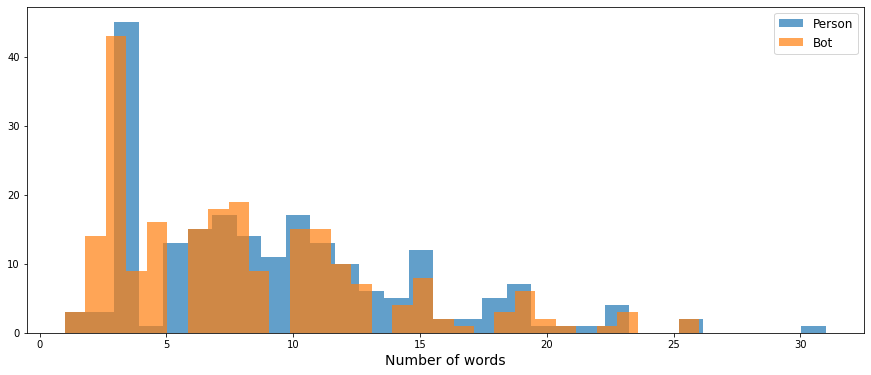

In [15]:
df_bot_result = obtain_word_analysis(df_save, "BotOriginalText")

bot_word_number = []
for my_list in df_bot_result["num_words_in_sentence"].tolist():
    bot_word_number += my_list
    
aute.stat_print(bot_word_number, "Number of words for BOT by sentence")

df_person_result = obtain_word_analysis(df_save, "PersonOriginalText")

person_word_number = []
for my_list in df_person_result["num_words_in_sentence"].tolist():
    person_word_number += my_list

aute.stat_print(person_word_number, "Number of words for Person by sentence")

plt.figure(figsize=(15, 6))

plt.hist(person_word_number, bins=31, alpha=0.7, label="Person")
plt.hist(bot_word_number, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Number of words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

Mean Number of words for ALL by sentence = 8.6247 +/- 5.6147 ; Median = 8.0 ; Min. =  1 ; Max. =  31


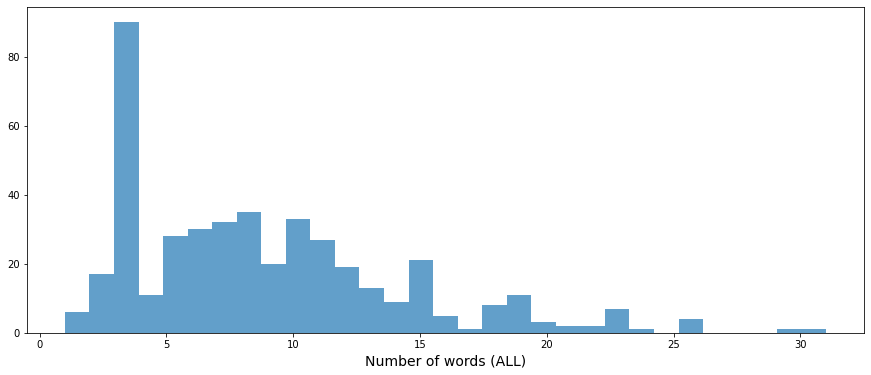

In [16]:
df_all_result = obtain_word_analysis(df_save, "AllOriginalText")

all_word_number = []
for my_list in df_all_result["num_words_in_sentence"].tolist():
    all_word_number += my_list

aute.stat_print(all_word_number, "Number of words for ALL by sentence")

plt.figure(figsize=(15, 6))

plt.hist(all_word_number, bins=31, alpha=0.7, label="All")
plt.xlabel("Number of words (ALL)", fontsize=14)

plt.show()

## WordCloud analysis

- Falta tokenizar las palabras, eliminar acentos y etc.

- Estaria bien establecer un protocolo para eliminar el nombre del sujeto.

- Estudiar el número y cuales son las stopwords localizadas en el Bot y en la persona. Ver si estas stopwords son las mismas para ambos o distintas, etc. Posiblemente el sujeto utilice más stopwords que el sujeto o quizá no. 

### Whole text

In [17]:
whole_text = " ".join(df_save["AllOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_words_list = [word for word in whole_text.split() if word not in spanish_stopwords_th]
uniq_words_list = list(set(all_words_list))
freq_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_words_list)==word)} for word in uniq_words_list
]
df_freq_all_words = pd.DataFrame(freq_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_all_words.head(15)

,Word,Times
0,bien,77
1,llamas?,67
2,pues,66
3,hola,60
4,verdad,52
5,cómo,50
6,tal,43
7,gracias,38
8,muchas,32
9,si,29


In [18]:
print("Number of different words", df_freq_all_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_all_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_all_words["Times"]), 5), 
      "Max", np.max(df_freq_all_words["Times"]), 
      "Min", np.min(df_freq_all_words["Times"]) )

Number of different words 395
Mean frequency 4.37215 +/- 8.61031 Max 77 Min 1


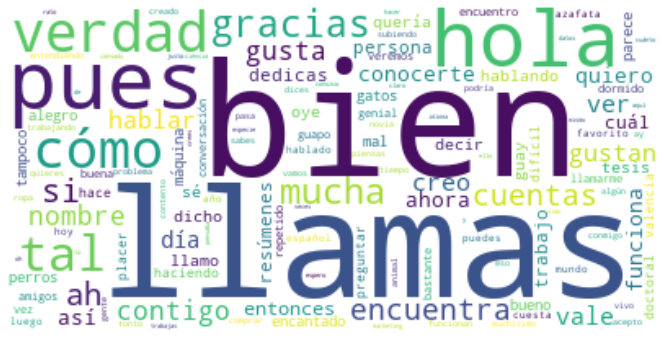

In [19]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bot analysis

In [20]:
whole_bot_text = " ".join(df_save["BotOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_bot_words_list = [word for word in whole_bot_text.split() if word not in spanish_stopwords_th]
uniq_bot_words_list = list(set(all_bot_words_list))
freq_bot_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_bot_words_list)==word)} for word in uniq_bot_words_list
]
df_freq_bot_words = pd.DataFrame(freq_bot_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_bot_words.head(15)

,Word,Times
0,bien,39
1,llamas?,33
2,hola,28
3,pues,28
4,cómo,23
5,verdad,23
6,gracias,21
7,tal,20
8,muchas,16
9,si,14


In [21]:
print("Number of different words", df_freq_bot_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_bot_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_bot_words["Times"]), 5), 
      "Max", np.max(df_freq_bot_words["Times"]), 
      "Min", np.min(df_freq_bot_words["Times"]) )

Number of different words 338
Mean frequency 2.5355 +/- 4.33783 Max 39 Min 1


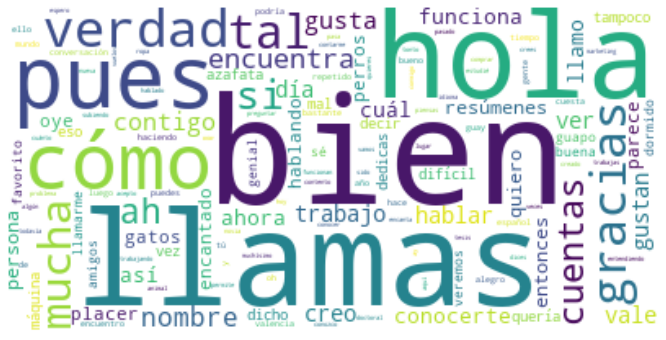

In [22]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_bot_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Analysis against Questionare

In [23]:
random_target = [np.random.randint(1, 5+1) for _ in range(df_save.shape[0])]
random_binary_target = [np.random.randint(0, 1+1) for _ in range(df_save.shape[0])]

In [24]:
df_save["MultilabelTarget"] = random_target
df_save["BinaryTarget"] = random_binary_target

In [25]:
aute.stat_print(df_save["MultilabelTarget"], "Realism degree score", precision=2)
aute.stat_print(100 * df_save["BinaryTarget"], "Repetition score", precision=2)

Mean Realism degree score = 2.88 +/- 1.41 ; Median = 3.0 ; Min. =  1 ; Max. =  5
Mean Repetition score = 54.55 +/- 49.79 ; Median = 100.0 ; Min. =  0 ; Max. =  100


In [26]:
print("Columns", df_save.columns)
df_save.head(5)

Columns Index(['SubjectId', 'FirstDate', 'LastDate', 'ConvTime_s', 'NumConv',
       'NumSamples', 'AllText', 'AllNumUniqWords', 'AllOriginalText',
       'AllNumWords', 'AllTimeAns', 'BotText', 'BotNumUniqWords',
       'BotOriginalText', 'BotNumWords', 'BotTimeAns', 'PersonText',
       'PersonNumUniqWords', 'PersonOriginalText', 'PersonNumWords',
       'PersonTimeAns', 'MultilabelTarget', 'BinaryTarget'],
      dtype='object')


,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,AllNumUniqWords,AllOriginalText,AllNumWords,...,BotOriginalText,BotNumWords,BotTimeAns,PersonText,PersonNumUniqWords,PersonOriginalText,PersonNumWords,PersonTimeAns,MultilabelTarget,BinaryTarget
0,Ana,1.658937e+09,1.658937e+09,196.524779,13,26,llamas. llamas. hol nombr hol nombr habl conti...,13,Como te llamas?. Como te llamas?. hola mi nomb...,53,...,Como te llamas?. hola mi nombre es estoy habla...,26,1.751842,llamas. hol nombr habl contigo. piens muerte. ...,13,Como te llamas?. hola mi nombre es estoy habla...,26,6.334660,5,1
1,jOSEID10,1.658677e+09,1.658677e+09,22.820666,3,6,llamas. llamas. bien tal cuentas. bien tal cue...,6,Como te llamas?. Como te llamas?. yo estoy muy...,17,...,Como te llamas?. yo estoy muy bien y tú qué ta...,8,0.852903,llamas. bien tal cuentas. much graci llam guap,6,Como te llamas?. yo estoy muy bien y tú qué ta...,8,3.680018,5,0
2,Joseid10,1.658677e+09,1.658678e+09,117.104444,10,20,llamas. llamas. hol encant volv conocerte. hol...,19,Como te llamas?. Como te llamas?. hola yo lo e...,65,...,Como te llamas?. hola yo lo encantado de volve...,32,0.917468,llamas. hol encant volv conocerte. plac mio en...,19,Como te llamas?. hola yo lo encantado de volve...,32,4.134324,1,1
3,Joseid8,1.658673e+09,1.658673e+09,11.624342,5,11,llamas. llamas. llamas. llamas. llamas. llamas...,1,Como te llamas?. Como te llamas?. Como te llam...,11,...,Como te llamas?. Como te llamas?. Como te llam...,5,0.370411,llamas. llamas. llamas. llamas. llamas. llam,1,Como te llamas?. Como te llamas?. Como te llam...,6,0.778020,3,1
4,Joseid8,1.658740e+09,1.658740e+09,89.409017,8,16,llamas. llamas. pues bien tal todo. pues bien ...,12,Como te llamas?. Como te llamas?. pues yo esto...,58,...,Como te llamas?. pues yo estoy muy bien y tú q...,29,2.042253,llamas. pues bien tal todo. pues bien cuentas....,12,Como te llamas?. pues yo estoy muy bien y tú q...,29,2.770404,2,1


Correlation value 0.2781295734718965
P-value -
Coefficients: 
 [0.33682318] 
Intercept: 
 2.5137078482416615
R-square: 0.08


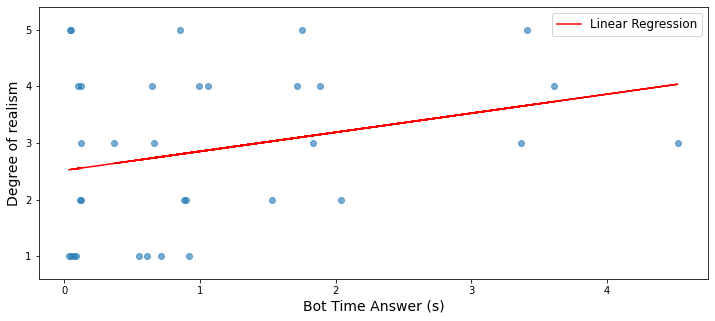

Correlation value 0.20415349576617645
P-value -
Coefficients: 
 [0.0330919] 
Intercept: 
 2.452604331234961
R-square: 0.04


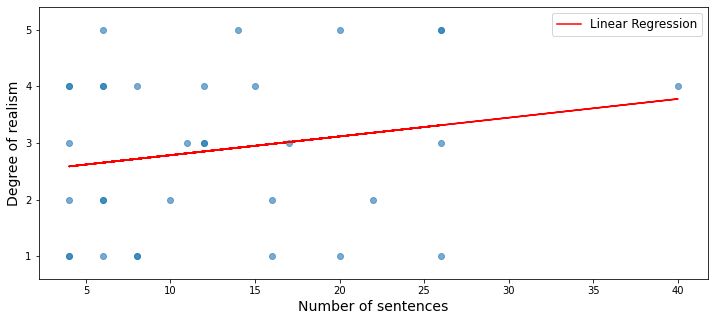

Correlation value 0.11792538273574642
P-value -
Coefficients: 
 [0.0124961] 
Intercept: 
 2.694754336761193
R-square: 0.01


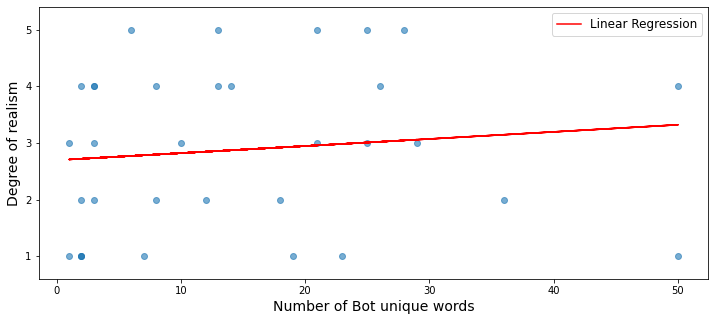

Correlation value 0.12116264448374789
P-value -
Coefficients: 
 [0.00636435] 
Intercept: 
 2.700393320945808
R-square: 0.01


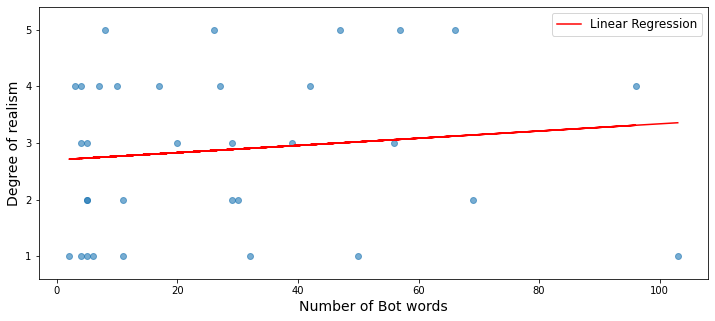

In [27]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="BotTimeAns", x_name="Bot Time Answer (s)", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="NumSamples", x_name="Number of sentences", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumUniqWords", x_name="Number of Bot unique words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumWords", x_name="Number of Bot words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

P-value 0.5844207082139206 with significance -


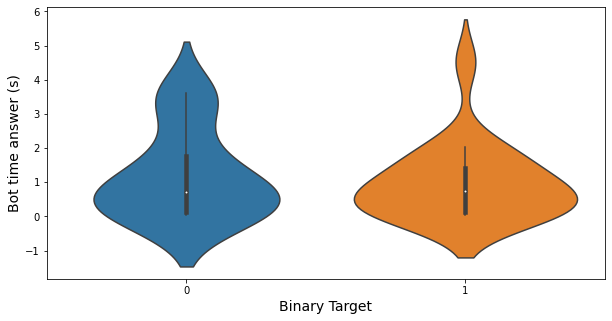

P-value 0.7622416597741911 with significance -


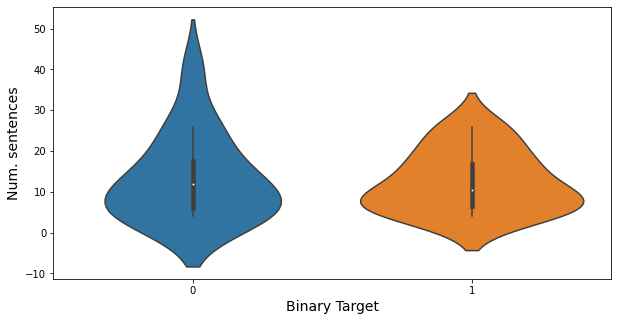

P-value 0.23862590641308457 with significance -


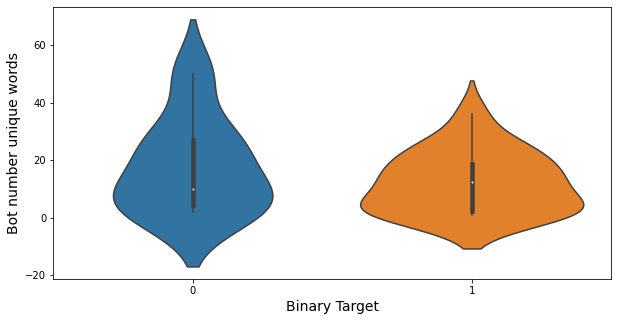

P-value 0.2849040265527642 with significance -


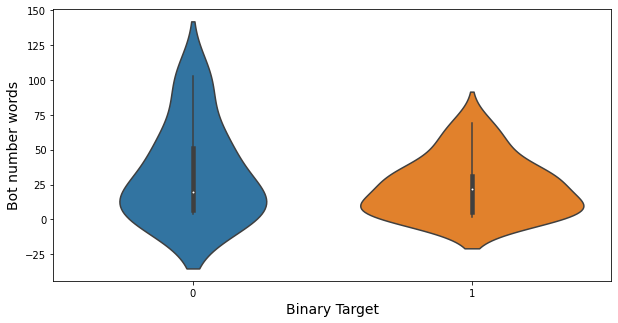

In [28]:
aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotTimeAns", y_name="Bot time answer (s)", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="NumSamples", y_name="Num. sentences", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumUniqWords", y_name="Bot number unique words", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumWords", y_name="Bot number words", 
                      violin_plot=True)

## Study sentence similarity

In [29]:
# ### Bot ###

all_bot_sentence_list = []
for sent in df_save["BotOriginalText"].tolist():
    all_bot_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_bot_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_bot_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_bot_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )
        
# ### Person ###
        
all_person_sentence_list = []
for sent in df_save["PersonOriginalText"].tolist():
    all_person_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_person_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_person_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_person_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )

Mean Bot sentence similarity = 0.2638 +/- 0.2214 ; Median = 0.2412 ; Min. =  -0.3106 ; Max. =  1.0
Mean Person sentence similarity = 0.3061 +/- 0.2312 ; Median = 0.2846 ; Min. =  -0.3152 ; Max. =  1.0


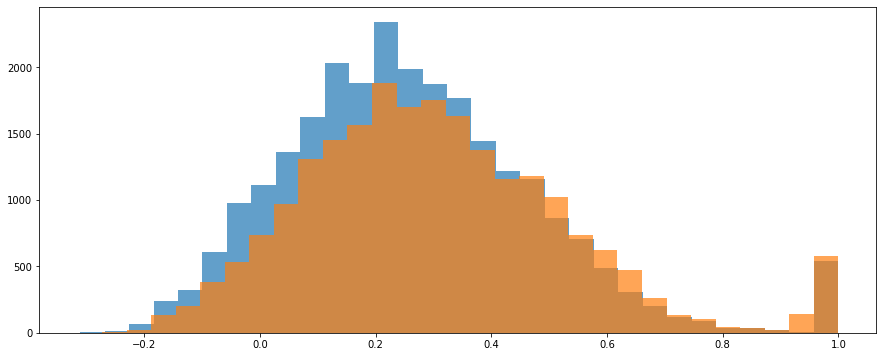

In [30]:
aute.stat_print(save_res_similarity_bot_list, "Bot sentence similarity")
aute.stat_print(save_res_similarity_person_list, "Person sentence similarity")

plt.figure(figsize=(15, 6))

plt.hist(save_res_similarity_bot_list, bins=31, alpha=0.7)
plt.hist(save_res_similarity_person_list, bins=31, alpha=0.7)

plt.show()

### Classifier

- Hacer un clasificador que sepa o pueda descubrir por las métricas obtenidas de la conversación si es un Bot o una persona. Lo interesante sería que NO.